#### The purpose of this notebook is to prepare the features

In [13]:
import numpy as np
import pandas as pd
import math
import random
from collections import Counter
import string

#NLP word learning packages
from glove import Corpus, Glove
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')

#for plot
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zijun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Zijun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
import pickle

In [15]:
def save_obj(obj, name ):
    with open('./'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [16]:
#import the merged data
filename = "GameData.csv"
df = pd.read_csv(filename,encoding = "mac_roman",sep='\t')

In [17]:
df.head(5)

,Unnamed: 0,new-price,sales-volume,release-year,genres,name,slug,rating,developers,platforms,tags,match
0,NaN,<lambda>,sum,<lambda>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,product-name-slug,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-30-great-games--family-party,7.88,16,2008.0,NaN,Family Party: 30 Great Games,family-party-30-great-games,0.00,NaN,Wii,[party],True
3,007--agent-under-fire,12.43,97,2002.0,NaN,James Bond 007: Agent Under Fire,james-bond-007-agent-under-fire,3.90,"Electronic Arts,Visceral Games,Electronic Arts...","Xbox,GameCube,PlayStation 2","Multiplayer,Singleplayer",True
4,007--everything-or-nothing,9.987066800602712,143,2004.0,[shooter],James Bond 007: Everything or Nothing,james-bond-007-everything-or-nothing,4.42,"Griptonite Games,Electronic Arts Redwood Shores","PlayStation 2,Game Boy Advance,Xbox,GameCube","Multiplayer,Singleplayer,cooperativeplay",True


In [37]:
#get rid of the first 2 rows
df = df.iloc[2:]

In [38]:
df = df.rename(columns={"Unnamed: 0": "product-name-slug"})

In [39]:
df = df.reset_index()

In [40]:
df.head(3)

,index,product-name-slug,new-price,sales-volume,release-year,genres,name,slug,rating,developers,platforms,tags,match
0,2,-30-great-games--family-party,7.88,16,2008.0,NaN,Family Party: 30 Great Games,family-party-30-great-games,0.00,NaN,Wii,[party],True
1,3,007--agent-under-fire,12.43,97,2002.0,NaN,James Bond 007: Agent Under Fire,james-bond-007-agent-under-fire,3.90,"Electronic Arts,Visceral Games,Electronic Arts...","Xbox,GameCube,PlayStation 2","Multiplayer,Singleplayer",True
2,4,007--everything-or-nothing,9.987066800602712,143,2004.0,[shooter],James Bond 007: Everything or Nothing,james-bond-007-everything-or-nothing,4.42,"Griptonite Games,Electronic Arts Redwood Shores","PlayStation 2,Game Boy Advance,Xbox,GameCube","Multiplayer,Singleplayer,cooperativeplay",True


In [41]:
df["match"].value_counts()

True    11367
Name: match, dtype: int64

In [42]:
#take the lines with match = True, i.e., games that can be found on rawg
df_game = df[df["match"]==True]

In [43]:
genres_series = []

In [44]:
#create a function to clean genres, platforms and developers
def clean_format(label,df_set):
    result = []
    for index,row in df_set.iterrows():
        data_label = row[label]
        if isinstance(data_label ,float):
            result.append("NA")
        else:
            if data_label[0] == "[":
                #if it's a single string and starts with "["
                temp = data_label[1:-1]
                result.append(temp.lower())
            else:
                #if the string is separated by commas
                temp = data_label.split(",")
                #transform to lower cases
                temp_lower = [x.lower() for x in temp]
                result.extend(temp_lower)
    return result

In [45]:
#clean genres
genres_output = clean_format("genres",df)

In [46]:
genres_output_unique = set(genres_output)

In [47]:
genres_output_unique

{'NA',
 'action',
 'adventure',
 'arcade',
 'board games',
 'board-games',
 'card',
 'casual',
 'educational',
 'family',
 'fighting',
 'indie',
 'massively multiplayer',
 'massively-multiplayer',
 'platformer',
 'puzzle',
 'racing',
 'role-playing-games-rpg',
 'rpg',
 'shooter',
 'simulation',
 'sports',
 'strategy'}

In [48]:
#clean developers
developers_output = clean_format("developers",df)

In [49]:
developers_output_unique = set(developers_output)

In [50]:
#clean platforms
platforms_output = clean_format("platforms",df)

In [51]:
platforms_output_unique = set(platforms_output)

In [52]:
len(set(platforms_output))

50

In [53]:
#clean tags
tags_output = clean_format("tags",df)

In [54]:
tags_output_unique = set(tags_output)

In [55]:
len(set(tags_output)) 

707

Several feature engineering:
1. Change release-year to age
2. For genres and platforms, Iwill extract unique values for each case and make them binary features(one-hot coding)
3. For tags and developers, I will extract specific values for each case in the most common ones, put the others into either "Others" and make them binary features(one-hot coding)
4. Change NaN to "NA" as a stand-alone value
5. Normalization if necessary
6. Word learning on game names using GloVe and tfidf

In [57]:
#change the release-year to age
df["age"] = 2019 - df["release-year"].astype(float)

In [58]:
#filter out the negative age
df = df[df["age"]>=0]

In [59]:
genres_output_unique

{'NA',
 'action',
 'adventure',
 'arcade',
 'board games',
 'board-games',
 'card',
 'casual',
 'educational',
 'family',
 'fighting',
 'indie',
 'massively multiplayer',
 'massively-multiplayer',
 'platformer',
 'puzzle',
 'racing',
 'role-playing-games-rpg',
 'rpg',
 'shooter',
 'simulation',
 'sports',
 'strategy'}

In [60]:
#make a copy of df
df_inuse = df.copy()

In [61]:
#clean genres and platforms
#first clean some typo errors
#clearly, board-games and board games are the same, and massively multiplayer and massively-multiplayer are the same
#let's keep 'board-games' and 'massively-multiplayer' 'massively multiplayer'
genres_output_unique.remove('board games')
genres_output_unique.remove('massively multiplayer')

In [62]:
#make each genre a binary feature
genres_features_label = list(genres_output_unique)

In [63]:
genres_features_label = ["genre-" + x for x in genres_features_label]

In [64]:
#example
genres_features_label[:5] 

['genre-puzzle',
 'genre-casual',
 'genre-role-playing-games-rpg',
 'genre-rpg',
 'genre-strategy']

In [65]:
#and prepare them binary features
#create placeholder in df_inuse
for title in genres_features_label:
    df_inuse[title] = 0

In [66]:
#populate genre features

def clean_format_features(label,df_set,label_type):
    for index,row in df_set.iterrows():
        data_label = row[label]
        if isinstance(data_label ,float):
            df_set.loc[index,label_type+ "-"+"NA"] = 1
        else:
            if data_label[0] == "[":
                #if it's a single string and starts with "["
                temp = data_label[1:-1]
                #modify 2 genres,only works when it's populating genres
                if temp == "board games":
                    temp = "board-games"
                elif temp == "massively multiplayer":
                    temp = "massively-multiplayer"
                df_set.loc[index,label_type+ "-"+temp] = 1
            else:
                #if the string is separated by commas and has multiple genres
                temp = data_label.split(",")
                #transform to lower cases
                temp_lower = [x.lower() for x in temp]

                for tt in temp_lower:
                    if tt == "board games":
                        tt = "board-games"
                    elif tt == "massively multiplayer":
                        tt = "massively-multiplayer"
                    df_set.loc[index,label_type+ "-"+tt] = 1
    return df_set

In [67]:
#populate genres
df_genres_cleaned = clean_format_features("genres",df_inuse,"genre")

In [68]:
#example expand to see below
df_genres_cleaned.iloc[3] 

index                                                                           5
product-name-slug                                      007--from-russia-with-love
new-price                                                                    8.94
sales-volume                                                                   99
release-year                                                               2005.0
genres                                                                   [action]
name                                        James Bond 007: From Russia with Love
slug                                         james-bond-007-from-russia-with-love
rating                                                                       3.91
developers                      Rebellion,Visceral Games,Electronic Arts Redwo...
platforms                                         GameCube,PlayStation 2,PSP,Xbox
tags                                                     Multiplayer,Singleplayer
match           

##### clean the platforms in the same fashion

In [69]:
platforms_features_label = list(platforms_output_unique)

In [70]:
platforms_features_label = ["platform-" + x for x in platforms_features_label]

In [71]:
for title in platforms_features_label:
    df_genres_cleaned[title] = 0

In [72]:
#populate the platform feature
df_platform_cleaned = clean_format_features("platforms",df_genres_cleaned,"platform")

In [73]:
#now populate developers: pick the most common 50 and put others in "others"
#example of the developers
developers_output[:5] 

['NA',
 'electronic arts',
 'visceral games',
 'electronic arts redwood shores',
 'griptonite games']

In [74]:
#get the top 50
developers_output_count = Counter(developers_output)
developers_output_top50 = developers_output_count.most_common(50)
#example
developers_output_top50[:7]

[('NA', 12677),
 ('nintendo', 267),
 ('sega', 260),
 ('sony interactive entertainment', 241),
 ('capcom', 238),
 (' inc.', 224),
 ('ubisoft', 210)]

In [75]:
developers_output_top50_list = [x[0] for x in developers_output_top50]

In [76]:
#need to add others
developers_output_top50_list.append("Others")

In [77]:
#these are the top 50 developers + NA + Others
#example of top 10
developers_output_top50_list[:10]

['NA',
 'nintendo',
 'sega',
 'sony interactive entertainment',
 'capcom',
 ' inc.',
 'ubisoft',
 'electronic arts',
 'konami-digital-entertainment',
 'activision']

In [78]:
#make it a dictionary so that it's faster to search in the process of feature engineering
developers_output_top50_dict = {}
for x in developers_output_top50_list:
    developers_output_top50_dict[x] = "developer-"+x

In [79]:
#modify the function earlier to fit developers and tags
def clean_format_features_2(label,df_set,label_dict):
    for index,row in df_set.iterrows():
        data_label = row[label]
        if isinstance(data_label ,float):
            #it's NA
            df_set.loc[index,label_dict["NA"]] = 1
        else:
            if data_label[0] == "[":
                #if it's a single string and starts with "["
                #means there's only one item -> we take the string without "[]"
                temp = data_label[1:-1]
                #modify if the item is not in the dictionary (not in the top50 or 25 depending on the label)
                if temp in label_dict:
                    df_set.loc[index,label_dict[temp]] = 1
                else:
                    #other developers
                    temp = "Others"
                    df_set.loc[index,label_dict[temp]] = 1
            else:
                #if the string is separated by commas and has multiple items
                temp = data_label.split(",")
                #transform to lower cases
                temp_lower = [x.lower() for x in temp]

                for tt in temp_lower:
                    if tt in label_dict:
                        df_set.loc[index,label_dict[tt]] = 1
                    else:
                        tt = "Others"
                        df_set.loc[index,label_dict[tt]] = 1
                    
    return df_set

In [80]:
#make a copy of the dataframe we worked on so far
df_new = df_platform_cleaned

In [81]:
#pre-populate the dataset with zeros
for title in developers_output_top50_dict.items():
    df_new[title[1]] = 0

In [82]:
#create features for developers
df_developers_cleaned = clean_format_features_2("developers",df_new,developers_output_top50_dict)

In [83]:
#example
df_developers_cleaned.loc[1,"developers"]

'Electronic Arts,Visceral Games,Electronic Arts Redwood Shores'

In [85]:
#save a copy
df_new = df_developers_cleaned

In [86]:
#clean tags in the same way (top 25 tags)
tags_output_count = Counter(tags_output)
tags_output_top25 = tags_output_count.most_common(25)
tags_output_top25_list = [x[0] for x in tags_output_top25]
tags_output_top25_list.append("Others")


tags_output_top25_dict = {}
for x in tags_output_top25_list:
    tags_output_top25_dict[x] = "tag-"+x

In [87]:
#pre-populate the dataset with zeros
for title in tags_output_top25_dict.items():
    df_new[title[1]] = 0
    
df_new.head(3)

,index,product-name-slug,new-price,sales-volume,release-year,genres,name,slug,rating,developers,...,tag-open world,tag-third person,tag-role-playing,tag-first-person,tag-anime,tag-steam leaderboards,tag-sci-fi,tag-fantasy,tag-classic,tag-Others
0,2,-30-great-games--family-party,7.88,16,2008.0,NaN,Family Party: 30 Great Games,family-party-30-great-games,0.00,NaN,...,0,0,0,0,0,0,0,0,0,0
1,3,007--agent-under-fire,12.43,97,2002.0,NaN,James Bond 007: Agent Under Fire,james-bond-007-agent-under-fire,3.90,"Electronic Arts,Visceral Games,Electronic Arts...",...,0,0,0,0,0,0,0,0,0,0
2,4,007--everything-or-nothing,9.987066800602712,143,2004.0,[shooter],James Bond 007: Everything or Nothing,james-bond-007-everything-or-nothing,4.42,"Griptonite Games,Electronic Arts Redwood Shores",...,0,0,0,0,0,0,0,0,0,0


In [88]:
#populate binary features on tags
df_tags_cleaned = clean_format_features_2("tags",df_new,tags_output_top25_dict)

##### Use GloVe Model to train game names

In [62]:
stop_words = set(stopwords.words('english')) 
len(stop_words)

179

In [63]:
#replace "-" with space in slug and every name would be a document. The corpus would be all the game titles.
df_new = df_tags_cleaned.copy()

In [64]:
len(df_new) 

22921

In [65]:
#We need to use "product-name-slug" as it has more information
#this information will be reflected in the word vectors

df_new["glove_name"] = df_new["product-name-slug"].str.replace("-"," ")

In [66]:
#get rid of all the punctuations

df_new["glove_name"] = df_new["glove_name"].str.translate(str.maketrans('', '', string.punctuation))

In [67]:
raw_lines = list(df_new["glove_name"])

In [68]:
raw_lines[:5]

[' 30 great games  family party',
 '007  agent under fire',
 '007  everything or nothing',
 '007  from russia with love',
 '007  nightfire']

In [69]:
lines = [str(x) if isinstance(x,float) else word_tokenize(x) for x in raw_lines]

In [70]:
lines[:5]

[['30', 'great', 'games', 'family', 'party'],
 ['007', 'agent', 'under', 'fire'],
 ['007', 'everything', 'or', 'nothing'],
 ['007', 'from', 'russia', 'with', 'love'],
 ['007', 'nightfire']]

In [71]:
#get rid of english stopwords
filtered_lines = []
for l in lines:
    temp = 0
    if l == 'nan':
        temp = ['nan']
    else:
        temp = [w for w in l if (w not in stop_words)]                  
    filtered_lines.append(temp)

In [72]:
filtered_lines[:5]

[['30', 'great', 'games', 'family', 'party'],
 ['007', 'agent', 'fire'],
 ['007', 'everything', 'nothing'],
 ['007', 'russia', 'love'],
 ['007', 'nightfire']]

In [73]:
#save filtred_lines
save_obj(filtered_lines,"filtered_lines_ver_2")

##### Check most common words (to double check if there's any residue punctuations)

In [74]:
flatten_lines =  [item for sublist in filtered_lines for item in sublist]
word_counter = Counter(flatten_lines)
word_counter.most_common(10)

[('2', 1524),
 ('edition', 1346),
 ('super', 618),
 ('3', 588),
 ('hits', 553),
 ('greatest', 509),
 ('world', 497),
 ('ii', 469),
 ('star', 334),
 ('limited', 313)]

### Train corpus to generate word vectors

In [84]:
#now train the corpus
corpus = Corpus() 

In [85]:
corpus.fit(filtered_lines, window=10)

In [86]:
#word embedding of 50
glove = Glove(no_components=50, learning_rate=0.01)

In [ ]:
glove.fit(corpus.matrix, epochs=100, no_threads=4, verbose=True)


In [89]:
glove.add_dictionary(corpus.dictionary)

In [90]:
glove.save('glove.model')

### checking some nouns to see the performance

In [92]:
print(glove.word_vectors[glove.dictionary['james']])

[-1.17551847e-02  3.49318246e-03 -7.36247677e-03 -5.81684218e-04
  1.60709179e-02 -1.60556152e-02 -9.50103587e-03 -1.79369361e-02
 -2.03046325e-03 -9.21001254e-03 -2.41359032e-03 -1.40437387e-02
  1.50779315e-03 -4.53476694e-03  1.51358009e-02  5.99008446e-03
  1.82915656e-02  1.03900317e-02  2.98498475e-03 -8.12029241e-03
 -1.51851942e-02  4.38632770e-05 -2.97198407e-03 -2.23461269e-03
  9.70166972e-03  4.64574258e-03 -6.46304124e-03  5.90850061e-03
  5.08052993e-03  8.19955587e-03  1.13340853e-02 -6.69748234e-03
  1.11432097e-02 -1.20453653e-02 -7.83708299e-03 -1.90230276e-02
  2.74151814e-03 -3.30955767e-03  3.79291130e-03  5.02019092e-04
 -9.44657111e-03  7.36983324e-03  1.02309175e-03  1.77399935e-02
  6.83406120e-03 -8.40784797e-05 -3.56567665e-03 -2.59994106e-04
  1.08685870e-02  3.64206472e-03]


In [93]:
print(glove.most_similar('james'))

[('chain', 0.6797487010755048), ('beyond', 0.6718289914696881), ('life', 0.6680892850901526), ('lord', 0.6635378525538799)]


In [94]:
print(glove.most_similar('007'))

[('ghosts', 0.774507821516691), ('dangerous', 0.7609869514848965), ('kain', 0.7509650698718577), ('midnight', 0.7502606648229427)]


In [95]:
print(glove.most_similar('kart'))

[('bros', 0.9075595059150345), ('marvel', 0.8023498252273618), ('robot', 0.7846872364796611), ('mario', 0.7820977731860321)]


In [96]:
print(glove.most_similar('assassins'))

[('creed', 0.9958809353294821), ('origins', 0.91098829580163), ('unity', 0.7843096386315662), ('complete', 0.7741943833913735)]


In [97]:
print(glove.most_similar('dragon'))

[('ball', 0.997991007754166), ('z', 0.9961156505084693), ('quest', 0.9813969777688422), ('budokai', 0.9806929131317625)]


In [98]:
print(glove.most_similar('hits'))

[('greatest', 0.9985580150437913), ('platinum', 0.9917909577690225), ('arcades', 0.943959673018269), ('persona', 0.9105458960466662)]


In [99]:
print(glove.most_similar('collectors'))

[('limited', 0.9991690578830298), ('edition', 0.9990406621332144), ('special', 0.9974176754067962), ('deluxe', 0.9968009548526875)]


In [93]:
#virtualize using t-SNE

%matplotlib inline

#function from https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne

def tsne_transform(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.dictionary:

        tokens.append(model.word_vectors[model.dictionary[word]])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=10)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    #return the PCA on 2 dimentions as well as their represented words
    return x,y,labels


In [94]:
#transform from a dimention of 50 to 2
x,y,labels_lst = tsne_transform(glove)

In [181]:
data_set=pd.DataFrame(list(zip(x,y,labels_lst)),columns=["x","y","labels"])

In [183]:
#example
data_set.head(5)

,x,y,labels
0,-55.970562,-20.638620,30
1,-35.121662,49.451874,great
2,-83.795242,-37.634739,games
3,-96.925682,23.063656,family
4,93.232582,29.460453,party


In [102]:
#size of the decomposed vectors
full_size = len(x)
full_size

10934

In [176]:
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

In [267]:
#algorithm to show the graph
#2 modes: full picture without labels or a zoomed version with labels
def tsne_plot(x,y,labels,x_min,x_max,y_min,y_max,picname,num_points,zoom):
    plt.figure(figsize=(16, 16)) 

    subdata = data_set.iloc[:num_points]
    
    if zoom == "on":
        # location for the zoom
        fig, ax = plt.subplots()
        ax.set(xlim=(x_min,x_max))
        ax.set(ylim=(y_min,y_max))
        p2 = sns.scatterplot(x="x", y="y",
                    hue="y",
                    data = subdata,
                    palette = cmap,
                    legend=False,
                    alpha=0.3,ax=ax)
        for i, point in subdata.iterrows():
            x_value = point["x"]
            y_value = point["y"]
            if (x_value>x_min and x_value<x_max) and (y_value > y_min and y_value <y_max):
                #generate a small random number for clearer label
                vv = random.uniform(-1,1)
                p2.text(x_value+0.03 + vv, y_value+vv, 
                point["labels"], horizontalalignment='left', 
                size='medium', color='black')
    else:
        p1 = sns.scatterplot(x="x", y="y",
                    hue="y",
                    data = subdata,
                    palette = cmap,
                    legend="brief",
                    alpha=0.3)
    
    plt.show()

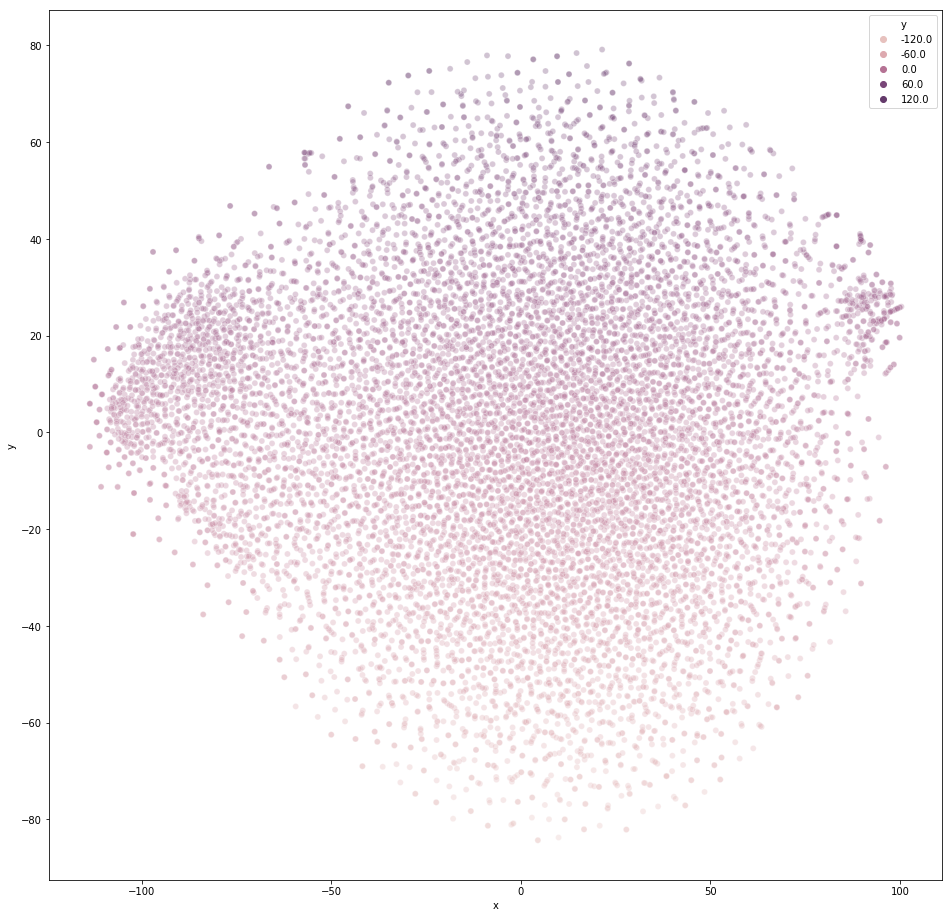

In [268]:
tsne_plot(x,y,labels_lst,-120,120,-100,100,"All_data",-1,"off")

<Figure size 1152x1152 with 0 Axes>

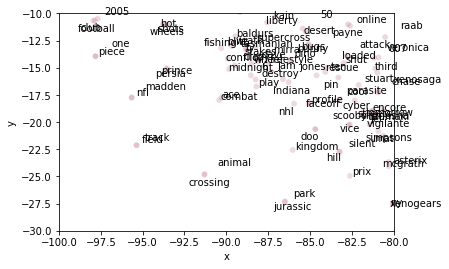

In [269]:
#zoom in some interesting areas
tsne_plot(x,y,labels_lst,-100,-80,-30,-10,"All_data",-1, "on")

<Figure size 1152x1152 with 0 Axes>

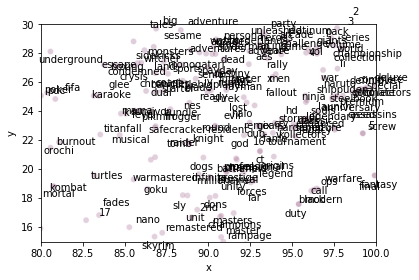

In [271]:
tsne_plot(x,y,labels_lst,80,100,15,30,"All_data",-1, "on")

<Figure size 1152x1152 with 0 Axes>

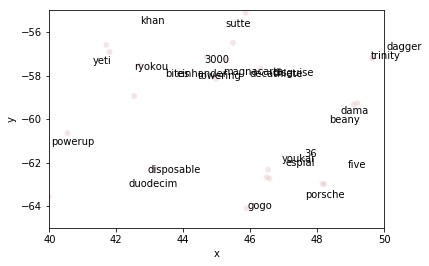

In [272]:
tsne_plot(x,y,labels_lst,40,50,-65,-55,"All_data",-1, "on")

<Figure size 1152x1152 with 0 Axes>

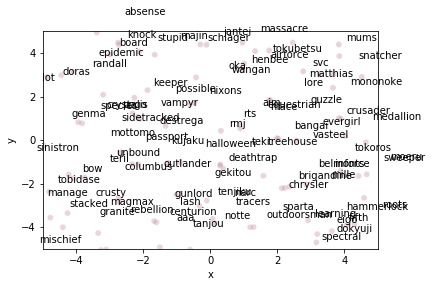

In [275]:
tsne_plot(x,y,labels_lst,-5,5,-5,5,"All_data",-1, "on")

###### tuning

The goal of the this section is to determine the optimal number of epochs and number of word embeddings
parameters tested:
1. no_components =[10,20,50,100]
2. epochs = [100,1000,5000]

The performance is judged by the nearest neighbors of some key words. A more thorough 

In conclusion, the more the number of components and epochs, the more complicated the training is and the longer it takes. 
To balance the time and the information embbed in the vectors, the number of components is set to be 50 with a number of epochs equaling 100.

The outputs of the following have been cleared for the html output. However, you are welcome to test the code.

In [278]:
glove_model_dict = {}

In [291]:
#the function will return a dictionary of glovel models that have been trained
def glove_fitting_models(glove_model_dict,learning_rate=0.05,no_components=20,epochs=100,no_threads=4,order=1):
    glove_temp = Glove(no_components, learning_rate)
    glove_temp.fit(corpus.matrix, epochs, no_threads, verbose=True)
    glove_temp.add_dictionary(corpus.dictionary)
    glove_temp.save('glove'+'_'+str(order)+'.model')
    glove_model_dict['glove'+'_'+str(order)] = glove_temp
    return glove_model_dict

In [ ]:
order = [1,2,3,4]
no_components_vector = [10,20,50,100]
epochs_num = 1000

#try different number of components
for i in order:
    glove_fitting_models(glove_model_dict,learning_rate=0.01,no_components=no_components_vector[i],epochs=epochs_num,no_threads=4,order=i)

In [ ]:
glove_model_dict
x_glove_2,y_glove_2,labels_lst_glove_2 = tsne_transform(glove_model_dict['glove_2'])

In [286]:
x_glove_2,y_glove_2,labels_lst_glove_2 = tsne_transform(glove_model_dict['glove_2'])

In [ ]:
size_glove_2 = len(labels_lst_glove_2)
size_glove_2 

#### Show the plots

In [ ]:
tsne_plot(x_glove_2,y_glove_2,labels_lst_glove_2,-100,100,-100,100,"All_data",size_glove_2,"off")

In [ ]:
tsne_plot(x_glove_2,y_glove_2,labels_lst_glove_2,-100,100,-100,100,"All_data",300,"off")

##### Zoom

In [ ]:
tsne_plot(x_glove_2,y_glove_2,labels_lst_glove_2,50,60,-85,-75,"All_data",-1,"on")

In [ ]:
tsne_plot(x_glove_2,y_glove_2,labels_lst_glove_2,20,30,-5,5,"All_data",-1,"on")

In [ ]:
tsne_plot(x_glove_2,y_glove_2,labels_lst_glove_2,-35,-25,-65,-55,"All_data",-1,"on")

In [ ]:
glove_model_dict_2 = {}
order2 = [5,6,7,8]
#try different number of components
for i in order2:
    glove_fitting_models(glove_model_dict_2,learning_rate=0.05,no_components=no_components_vector[i-4],epochs=5000,no_threads=4,order=i)

In [ ]:
glove_model_dict_2

In [ ]:
x_glove_6,y_glove_6,labels_lst_glove_6 = tsne_transform(glove_model_dict_2['glove_6'])

In [ ]:
size_glove_6= len(labels_lst_glove_6)
size_glove_6 

#### Show the plots

In [ ]:
tsne_plot(x_glove_6,y_glove_6,labels_lst_glove_6,-100,100,-100,100,"All_data",size_glove_6,"off")

##### The groups in the graph looks more distinct with epoch = 5000 (the above model was using epoch = 5000 and a word size of 10)

#### With 300 data points:

In [ ]:
tsne_plot(x_glove_6,y_glove_6,labels_lst_glove_6,-100,100,-100,100,"All_data",300,"off")

##### Details

In [ ]:
tsne_plot(x_glove_6,y_glove_6,labels_lst_glove_6,20,30,-85,-75,"All_data",-1,"on")

In [ ]:
tsne_plot(x_glove_6,y_glove_6,labels_lst_glove_6,-35,-25,-65,-55,"All_data",-1,"on")

##### As a rough test, we will look at the most similar words to the following:
1.james
2.assassins

###### word embedding = 20 and epoch = 5000

In [303]:
#check some key word
#5000 trainings dimention 20
print(glove.word_vectors[glove_model_dict_2['glove_6'].dictionary['james']])
print(glove_model_dict_2['glove_6'].most_similar('james'))
print(glove_model_dict_2['glove_6'].most_similar('assassins'))

[ 0.00969021  0.00221471  0.01780448  0.00836456  0.00167293 -0.00227189
 -0.00914827 -0.00121577 -0.01188478 -0.00552771 -0.01924564  0.00364726
 -0.0033934  -0.0008946   0.01006231 -0.00888368 -0.01723945  0.00289619
  0.0022534   0.00833407 -0.01552999  0.00694825  0.00347814  0.01196413
 -0.01477575 -0.01008654 -0.00688206 -0.01555829  0.01357057 -0.00617438
  0.00871928 -0.00489974  0.00446209  0.00397953 -0.00439243  0.00321113
  0.01160974 -0.0080034  -0.00352542 -0.0075956  -0.01746714 -0.00271227
  0.00391657  0.01241669  0.00736378  0.00641597  0.00831864  0.00614372
  0.0083404  -0.00301123]
[('jesse', 0.8872831144624608), ('pond', 0.6090194975969832), ('phantasy', 0.5989426914641991), ('fugitive', 0.5817004985007167)]
[('creed', 0.6246589972382892), ('kitten', 0.5709702075821539), ('parrot', 0.5344696410825592), ('anno', 0.497687034429463)]


###### word embedding = 20 and epoch = 1000

In [304]:
#1000 trainings dimention 20
print(glove.word_vectors[glove_model_dict['glove_2'].dictionary['james']])
print(glove_model_dict['glove_2'].most_similar('james'))
print(glove_model_dict['glove_2'].most_similar('assassins'))

[ 0.00969021  0.00221471  0.01780448  0.00836456  0.00167293 -0.00227189
 -0.00914827 -0.00121577 -0.01188478 -0.00552771 -0.01924564  0.00364726
 -0.0033934  -0.0008946   0.01006231 -0.00888368 -0.01723945  0.00289619
  0.0022534   0.00833407 -0.01552999  0.00694825  0.00347814  0.01196413
 -0.01477575 -0.01008654 -0.00688206 -0.01555829  0.01357057 -0.00617438
  0.00871928 -0.00489974  0.00446209  0.00397953 -0.00439243  0.00321113
  0.01160974 -0.0080034  -0.00352542 -0.0075956  -0.01746714 -0.00271227
  0.00391657  0.01241669  0.00736378  0.00641597  0.00831864  0.00614372
  0.0083404  -0.00301123]
[('pond', 0.8891512775335156), ('bond', 0.7628836791370942), ('ufo', 0.7210971733635188), ('zoop', 0.7203082050672449)]
[('creed', 0.9284696812781685), ('unity', 0.8663008942709455), ('origins', 0.6743881996219291), ('tenchu', 0.6217114336512592)]


###### word embedding = 10 and epoch = 1000

In [305]:
#1000 trainings dimention 10
print(glove.word_vectors[glove_model_dict['glove_1'].dictionary['james']])
print(glove_model_dict['glove_1'].most_similar('james'))
print(glove_model_dict['glove_1'].most_similar('assassins'))

[ 0.00969021  0.00221471  0.01780448  0.00836456  0.00167293 -0.00227189
 -0.00914827 -0.00121577 -0.01188478 -0.00552771 -0.01924564  0.00364726
 -0.0033934  -0.0008946   0.01006231 -0.00888368 -0.01723945  0.00289619
  0.0022534   0.00833407 -0.01552999  0.00694825  0.00347814  0.01196413
 -0.01477575 -0.01008654 -0.00688206 -0.01555829  0.01357057 -0.00617438
  0.00871928 -0.00489974  0.00446209  0.00397953 -0.00439243  0.00321113
  0.01160974 -0.0080034  -0.00352542 -0.0075956  -0.01746714 -0.00271227
  0.00391657  0.01241669  0.00736378  0.00641597  0.00831864  0.00614372
  0.0083404  -0.00301123]
[('pond', 0.9211753231128268), ('bond', 0.8019054384414325), ('zekkeiban', 0.7590765780819447), ('suimei', 0.7491866922992734)]
[('creed', 0.9639949388965815), ('unity', 0.9227633110654901), ('barnstorming', 0.7778977938213053), ('gamebreaker', 0.7602664243492462)]


###### word embedding = 50 and epoch = 1000

In [306]:
#1000 trainings dimention 50
print(glove.word_vectors[glove_model_dict['glove_3'].dictionary['james']])
print(glove_model_dict['glove_3'].most_similar('james'))
print(glove_model_dict['glove_3'].most_similar('assassins'))

[ 0.00969021  0.00221471  0.01780448  0.00836456  0.00167293 -0.00227189
 -0.00914827 -0.00121577 -0.01188478 -0.00552771 -0.01924564  0.00364726
 -0.0033934  -0.0008946   0.01006231 -0.00888368 -0.01723945  0.00289619
  0.0022534   0.00833407 -0.01552999  0.00694825  0.00347814  0.01196413
 -0.01477575 -0.01008654 -0.00688206 -0.01555829  0.01357057 -0.00617438
  0.00871928 -0.00489974  0.00446209  0.00397953 -0.00439243  0.00321113
  0.01160974 -0.0080034  -0.00352542 -0.0075956  -0.01746714 -0.00271227
  0.00391657  0.01241669  0.00736378  0.00641597  0.00831864  0.00614372
  0.0083404  -0.00301123]
[('pond', 0.8884993448243748), ('bond', 0.763340742522813), ('shockwave', 0.6902764293024378), ('ufo', 0.6860765262054005)]
[('creed', 0.9066377120867063), ('unity', 0.781581152524177), ('tenchu', 0.6501596713511026), ('origins', 0.6034974081512561)]


###### word embedding = 20 and epoch = 100

In [307]:
#100 trainings dimention 20
print(glove.word_vectors[glove.dictionary['james']])
print(glove.most_similar('james'))
print(glove.most_similar('assassins'))

[ 0.00969021  0.00221471  0.01780448  0.00836456  0.00167293 -0.00227189
 -0.00914827 -0.00121577 -0.01188478 -0.00552771 -0.01924564  0.00364726
 -0.0033934  -0.0008946   0.01006231 -0.00888368 -0.01723945  0.00289619
  0.0022534   0.00833407 -0.01552999  0.00694825  0.00347814  0.01196413
 -0.01477575 -0.01008654 -0.00688206 -0.01555829  0.01357057 -0.00617438
  0.00871928 -0.00489974  0.00446209  0.00397953 -0.00439243  0.00321113
  0.01160974 -0.0080034  -0.00352542 -0.0075956  -0.01746714 -0.00271227
  0.00391657  0.01241669  0.00736378  0.00641597  0.00831864  0.00614372
  0.0083404  -0.00301123]
[('pond', 0.7085986497500207), ('burst', 0.6786504428360346), ('book', 0.6519728864166612), ('reverie', 0.6513098448726607)]
[('creed', 0.9960528033447483), ('origins', 0.9304566378930905), ('legacy', 0.8288224939451014), ('unity', 0.7972232055947592)]


Base on the previous 2 sections, we would expect the word vectors to add some values to the price prediction. However, the value could be improved through a larger number of word embeddings, more epochs or even a bigger corpus.
But fur now we will use a size of 50 and epoch of 100.

##### end of  tuning

The next step is to generate actual vectors to be used in the features

In [310]:
#try first with the vectors from epoch = 100 and dimention 20
#and take the mean of all the words available in the title
sentence_vectors = []
real_vectors = []
embed_n = 50
for each_line in filtered_lines:
    temp = 0
    sum_temp = 0
    if (each_line == 'nan') or (len(each_line) == 0):
        #the vector is 0 if the name is "nan"
        temp = [0]*embed_n
    else:
        #2 vectors are being generated as 2 useful inputs later in the analysis
        #1: mean of the word vectors -> sentence vector
        #2: the word vectors themselves
        temp = np.mean([glove.word_vectors[glove.dictionary[w]] for w in each_line],axis=0)    
        temp_realv = [glove.word_vectors[glove.dictionary[w]] for w in each_line]
    sentence_vectors.append(temp) 
    real_vectors.append(temp_realv)

In [311]:
#save vectors
save_obj(real_vectors,"word_vectors_size50")
save_obj(sentence_vectors,"mean_word_vectors_size50")

In [312]:
#add this into df_new
df_new["glove_vectors"] = sentence_vectors

In [313]:
#save as the second version
df_new.to_pickle("./CleanedData_secondversion.pk1")

##### Create vectors using TF-IDF

In [314]:
#turn filtered lines into a list of sentences with spaces and without stopwords 
key_sentences = []

for x in filtered_lines:
    temp = " ".join(x)
    key_sentences.append(temp)

In [315]:
key_sentences[:5]

['30 great games family party',
 '007 agent fire',
 '007 everything nothing',
 '007 russia love',
 '007 nightfire']

In [316]:
vectorizer = TfidfVectorizer(token_pattern=r'\S+')
weights = vectorizer.fit_transform(key_sentences)

In [317]:
feature_names = vectorizer.get_feature_names()
doc = 2
feature_index = weights[doc,:].nonzero()[1]
tfidf_scores = zip(feature_index, [weights[doc, x] for x in feature_index])

In [318]:
feature_names[:5]

['0', '001', '007', '0079', '009']

In [319]:
for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    print(w, s)

007 0.4809126277743323
everything 0.6271752202904937
nothing 0.6126779639425244


In [321]:
#now get the scores for each line
score_dict = {}
line_dict = {}

total_lines = len(filtered_lines)

for i in range(total_lines):
    line_dict = {}
    feature_index = weights[i,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [weights[i, x] for x in feature_index])
    for w, s in [(feature_names[ii], s) for (ii, s) in tfidf_scores]:
        line_dict[w] = s
    
    #append the score for the line to the total dictionary
    score_dict[i] = line_dict

In [325]:
score_dict[0]

{'30': 0.4862269826481783,
 'great': 0.46833112376457753,
 'games': 0.4113234749802846,
 'family': 0.46357338416187177,
 'party': 0.4002024441268554}

In [326]:
#export and save the dictionary of score
save_obj(score_dict,"tfidf_dict_size50")

In [327]:
len(score_dict)

22921

In [328]:
len(filtered_lines)

22921

In [332]:
total_lines

22921

##### apply tfidf to the sentence vectors as the weight

In [334]:
#score_dict{index:{word:score....word:score....}}
#real_vectors 21219*n*20

tfidf_vector = []
v_sum = 0
s_sum = 0

for i in range(total_lines):
    v_sum = 0
    s_sum = 0
    s_temp = 0
    temp = 0
    n=len(filtered_lines[i])
    if n>0:
        for w in range(n):
            word = filtered_lines[i][w]
            s_temp = score_dict[i][str(word)]
            v_sum = v_sum + real_vectors[i][w] * s_temp
            s_sum = s_sum + s_temp
            temp = v_sum/s_sum
    else:
        temp = 0
    
    tfidf_vector.append(temp)


In [335]:
#save the tfidf adjusted vector
save_obj(tfidf_vector,"tfidf_vector_corpus_size50")

In [336]:
#add tfidf_vector to the dataframe
#add this into df_new
df_new["tfidf_vectors"] =tfidf_vector

In [337]:
#save this new dataset

save_obj(df_new,"df_tfidf_size50")